<a href="https://colab.research.google.com/github/Deadspree/Learn-Pytorch-Tutorials-1/blob/main/Cats_and_Dog_finetuning_transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Importing

In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: test/cats/cat_1.jpg     
  inflating: test/cats/cat_106.jpg   
  inflating: test/cats/cat_109.jpg   
  inflating: test/cats/cat_113.jpg   
  inflating: test/cats/cat_114.jpg   
  inflating: test/cats/cat_116.jpg   
  inflating: test/cats/cat_118.jpg   
  inflating: test/cats/cat_119.jpg   
  inflating: test/cats/cat_124.jpg   
  inflating: test/cats/cat_140.jpg   
  inflating: test/cats/cat_147.jpg   
  inflating: test/cats/cat_156.jpg   
  inflating: test/cats/cat_158.jpg   
  inflating: test/cats/cat_162.jpg   
  inflating: test/cats/cat_18.jpg    
  inflating: test/cats/cat_190.jpg   
  inflating: test/cats/cat_203.jpg   
  inflating: test/cats/cat_223.jpg   
  inflating: test/cats/cat_234.jpg   
  inflating: test/cats/cat_244.jpg   
  inflating: test/cats/cat_251.jpg   
  inflating: test/cats/cat_255.jpg   
  inflating: test/cats/cat_268.jpg   
  inflating: test/cats/cat_279.jpg   
  inflating: test/cats/cat_281.jpg   
  inflating: test/c

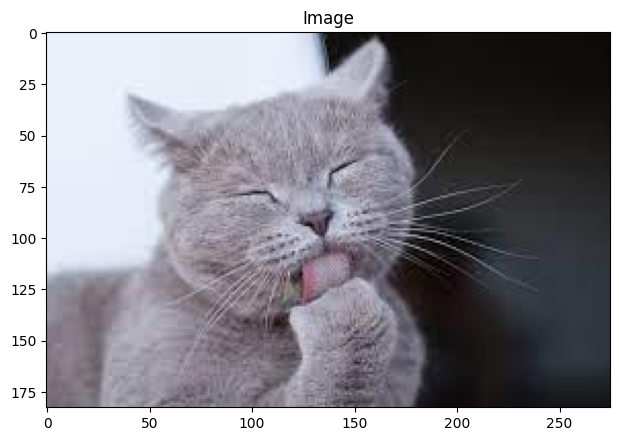

In [2]:
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

image = read_image("/content/train/cats/cat_100.jpg").permute(1,2,0)
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image)



In [3]:
image.shape

torch.Size([183, 275, 3])

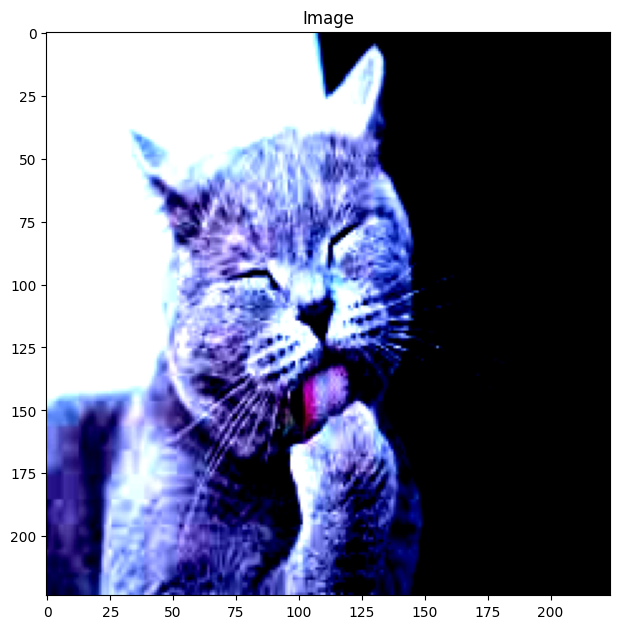

In [4]:
from torchvision import transforms
from PIL import Image

# Define your transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

def load_image(image_path):
    image = Image.open(image_path)

    # Check for image mode (grayscale or RGB)
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert grayscale images to RGB

    # Apply transformations
    image = data_transforms(image)

    return image

# Example usage
image_tensor = load_image('/content/train/cats/cat_100.jpg').permute(1,2,0)
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image_tensor)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Count the number of images

In [7]:
import os


In [8]:
def count_images_in_directory(img_directory, extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')):
    count = 0
    for root, dirs, files in os.walk(img_directory):
        for file in files:
            if file.lower().endswith(extensions):
                count += 1
    return count
directory = '/content/train'
total = 0
# Specify the path to your directory
for filename in os.listdir(directory):
  file_path = os.path.join(directory, filename)
  total += count_images_in_directory(file_path)



# Get the number of images
print(total)

557


In [9]:
directory = '/content/test'
total = 0
# Specify the path to your directory
for filename in os.listdir(directory):
  file_path = os.path.join(directory, filename)
  total += count_images_in_directory(file_path)

print(total)

140


### Create a Validation Set

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),# Resize images to 224x224
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize, always use this
])

data_dir = "/content/train"
full_dataset = datasets.ImageFolder(data_dir, transform = data_transforms)

#Define Split sizes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create a DataLoader objects for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Load and Train on a pre-trained model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split


Use for very similar problem: humans-humans

In [12]:
model = models.resnet18(pretrained=True)

#Modify the final layer
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes) # Important part
#Set device(one CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #Use small learning rate for fine tuning problems becaue we want the weights to adjust slighty to fit our problem
#Train the model
num_epochs = 10
for epoch in range(num_epochs):
  model.train() # Set the model to training mode
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    #Zero the parameter gradients
    optimizer.zero_grad()

    #Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    #Backward pass and optimization
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Print stats for the epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

  #Evaluate the model
  model.eval() #Set the model to evaluation mode
  correct = 0
  total = 0

  with torch.no_grad(): # NO gradient tracking during evaluation
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch [1/10], Loss: 0.5267
Accuracy on the validation set: 91.96%
Epoch [2/10], Loss: 0.1811
Accuracy on the validation set: 95.54%
Epoch [3/10], Loss: 0.0961
Accuracy on the validation set: 95.54%
Epoch [4/10], Loss: 0.0620
Accuracy on the validation set: 95.54%
Epoch [5/10], Loss: 0.0465
Accuracy on the validation set: 95.54%
Epoch [6/10], Loss: 0.0291
Accuracy on the validation set: 95.54%
Epoch [7/10], Loss: 0.0282
Accuracy on the validation set: 95.54%
Epoch [8/10], Loss: 0.0206
Accuracy on the validation set: 95.54%
Epoch [9/10], Loss: 0.0166
Accuracy on the validation set: 95.54%
Epoch [10/10], Loss: 0.0192
Accuracy on the validation set: 95.54%


Trying on test set

In [19]:
import torch
from torch.utils.data import DataLoader

# Assuming you have these already defined:
# - model: your trained model
# - test_dataset: your test dataset
# - criterion: the loss function used during training (e.g., nn.CrossEntropyLoss)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),# Resize images to 224x224
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize, always use this
])

test_dir = "/content/test"
test_dataset = datasets.ImageFolder(test_dir, transform = data_transforms)

# Create DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize metrics
total_loss = 0.0
correct = 0
total = 0

# Disable gradient calculations
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update loss
        total_loss += loss.item()

        # Get predictions and update accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
average_loss = total_loss / len(test_loader)
accuracy = correct / total

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')



Test Loss: 0.0982, Test Accuracy: 96.43%


Transfer Learning

Use for somewhat similar problems: Humans-Animals

In [20]:
model_trans = models.resnet18(weights = "IMAGENET1K_V1")

for param in model_trans.parameters():#Difference between Transfer Learning and Fine Tuning, The rest is the same
  param.required_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_trans.fc.in_features
model_trans.fc = nn.Linear(num_ftrs, 2)

#Set device(one CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_trans.to(device)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_trans.parameters(), lr=0.001, momentum=0.9) #Use small learning rate for fine tuning problems becaue we want the weights to adjust slighty to fit our problem
#Train the model
num_epochs = 10
for epoch in range(num_epochs):
  model_trans.train() # Set the model to training mode
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    #Zero the parameter gradients
    optimizer.zero_grad()

    #Forward pass
    outputs = model_trans(inputs)
    loss = criterion(outputs, labels)

    #Backward pass and optimization
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Print stats for the epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

  #Evaluate the model
  model_trans.eval() #Set the model to evaluation mode
  correct = 0
  total = 0

  with torch.no_grad(): # NO gradient tracking during evaluation
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_trans(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Loss: 0.5112
Accuracy on the validation set: 92.86%
Epoch [2/10], Loss: 0.1858
Accuracy on the validation set: 92.86%
Epoch [3/10], Loss: 0.0872
Accuracy on the validation set: 96.43%
Epoch [4/10], Loss: 0.0558
Accuracy on the validation set: 95.54%
Epoch [5/10], Loss: 0.0401
Accuracy on the validation set: 95.54%
Epoch [6/10], Loss: 0.0406
Accuracy on the validation set: 96.43%
Epoch [7/10], Loss: 0.0312
Accuracy on the validation set: 96.43%
Epoch [8/10], Loss: 0.0215
Accuracy on the validation set: 95.54%
Epoch [9/10], Loss: 0.0190
Accuracy on the validation set: 96.43%
Epoch [10/10], Loss: 0.0140
Accuracy on the validation set: 96.43%


In [21]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),# Resize images to 224x224
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize, always use this
])

test_dir = "/content/test"
test_dataset = datasets.ImageFolder(test_dir, transform = data_transforms)

# Create DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model_trans.eval()

# Initialize metrics
total_loss = 0.0
correct = 0
total = 0

# Disable gradient calculations
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_trans(inputs)
        loss = criterion(outputs, labels)

        # Update loss
        total_loss += loss.item()

        # Get predictions and update accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
average_loss = total_loss / len(test_loader)
accuracy = correct / total

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.1005, Test Accuracy: 95.71%
